# Turning point analysis
- Work flow
    1. turn tick data into daily data
        - findataflow
    1. For each maturity
        - detect turing points (N)
            - N = 1, 2, 3, ...
        - combine turning points
    1. summarize turning points by day-to-maturity
        - frequency
        - slope
        - duration
        - optimal lambda


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# pretty print for consecutive dfs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime


## pararmeter

In [43]:
N = 1

## turn tick data into daily data

In [44]:
import config as cfg

def get_maturity(series_date):
    settlements = pd.to_datetime(pd.read_csv(cfg.PATH_SETTLEMENTS).settlement).dt.date
    maturities = series_date.where(series_date.isin(settlements)).fillna(method='bfill')
    maturities.where(maturities >= settlements.min(), inplace = True)
    return maturities


In [45]:
from findataflow.dataprocs import resample

In [46]:
df_ohlc = resample.get_OHLCV_given_frequency(symbol='TXF', freq='1D')
df_ohlc.reset_index(inplace=True)
df_ohlc.rename(columns={'index': 'tx_datetime'}, inplace=True)
df_ohlc['tx_datetime'] = df_ohlc.tx_datetime.dt.date
df_ohlc.loc[df_ohlc.shape[0]] = [datetime.date(2014,3,19), 8734, 8742, 8684, 8696, np.nan]#TODO: no data
df_ohlc.sort_values('tx_datetime', inplace=True)
df_ohlc['maturity'] = get_maturity(df_ohlc.tx_datetime)
df_ohlc['day_to_maturity'] = (df_ohlc.tx_datetime - df_ohlc.maturity).dt.days
df_ohlc.head()

transformed OHLCV at frequency 1D
reading cache of TXF in 1D OHLCV


,tx_datetime,open,high,low,close,vol,maturity,day_to_maturity
0,2011-01-03,9000.0,9030.0,8995.0,9020.0,122732.0,2011-01-19,-16
1,2011-01-04,9030.0,9030.0,8974.0,8978.0,124896.0,2011-01-19,-15
2,2011-01-05,8967.0,9005.0,8791.0,8838.0,331662.0,2011-01-19,-14
3,2011-01-06,8859.0,8876.0,8815.0,8869.0,165020.0,2011-01-19,-13
4,2011-01-07,8866.0,8883.0,8727.0,8753.0,257504.0,2011-01-19,-12


In [47]:
df_ohlc.tail()

,tx_datetime,open,high,low,close,vol,maturity,day_to_maturity
1995,2019-02-14,10044.0,10124.0,10034.0,10080.0,193056.0,2019-02-20,-6
1996,2019-02-15,10040.0,10116.0,10022.0,10042.0,223160.0,2019-02-20,-5
1997,2019-02-18,10111.0,10161.0,10098.0,10135.0,193704.0,2019-02-20,-2
1998,2019-02-19,10123.0,10158.0,10104.0,10142.0,143182.0,2019-02-20,-1
1999,2019-02-20,10183.0,10262.0,10177.0,10256.0,136116.0,2019-02-20,0


## turing point at maturity-level
- detect turing points (N)
    - N = 1, 2, 3, ...
- combine turning points

In [149]:
def get_marked_turnpt(prc_ohlc, N): 
    assert 'tx_datetime' in prc_ohlc.columns, 'tx_datetime is not in column name list'
    assert 'low' in prc_ohlc.columns, 'low is not in column name list'
    assert 'high' in prc_ohlc.columns, 'high is not in column name list'
    
    df_prc = prc_ohlc[['tx_datetime']].copy()
    window = prc_ohlc[['close']].rolling(window = N * 2 + 1, center = True, min_periods = (N+1)+1)
    df_prc['N'] = N
    df_prc['is_turnpt_upward'] = (prc_ohlc.close == window.min().close).astype(int)
    df_prc['is_turnpt_downward'] = (prc_ohlc.close == window.max().close).astype(int)
    df_prc['is_turnpt'] = df_prc.is_turnpt_upward + df_prc.is_turnpt_downward * (-1)
    return df_prc

def get_combined_turnpt(df_turnpt_ohlc):
    rows_turnpt = []
    row_candidate = None
    for idx, row_current in df_turnpt_ohlc.iterrows():
        # for first turning point
        if row_current.is_turnpt == 0: 
            continue

        # for first turning point
        if row_candidate is None: 
            row_candidate = row_current
            continue    

        # for every following turning points
        if row_candidate.is_turnpt != row_current.is_turnpt:
            rows_turnpt.append(row_candidate[['N', 'tx_datetime', 'is_turnpt_upward', 'is_turnpt_downward']])
            row_candidate = row_current
        else:
            direction = row_candidate.is_turnpt
            if direction > 0:
                row_candidate = row_current if (row_current.close < row_candidate.close) else row_candidate
            elif direction < 0:
                row_candidate = row_current if (row_current.close > row_candidate.close) else row_candidate
            else:
                raise ValueError('direction can only be -1 or 1.')
    df_turnpt_combined = pd.DataFrame(rows_turnpt)
    df_turnpt_ohlc = df_turnpt_ohlc[['tx_datetime'] + [col for col in df_turnpt_ohlc.columns if col not in df_turnpt_combined.columns]]
    df_turnpt_ohlc_combined = df_turnpt_ohlc.merge(df_turnpt_combined, on='tx_datetime', how='left')
    return df_turnpt_ohlc_combined

def plot_turnpt(df_turnpt_ohlc, N):
    df_plot = df_turnpt_ohlc.query(f'N == {N}').copy()
    df_plot.set_index('tx_datetime', inplace=True)
    def find_loc(df, dates):
        return [df.index.get_loc(date) for date in dates]

    dates_upward = df_plot.query('is_turnpt_upward==1').index
    df_plot.close.plot.line(figsize=(20, 5), color='white', markevery=find_loc(df_plot, dates_upward), marker='^', markerfacecolor='red', markeredgewidth=0.0)

    dates_downward = df_plot.query('is_turnpt_downward==1').index
    df_plot.close.plot.line(figsize=(20, 5), color='black', markevery=find_loc(df_plot, dates_downward), marker='v', markerfacecolor='green', markeredgewidth=0.0)
    plt.title(f'N: {N}')
    
def get_prc_diff(dt_start, dt_end):
    if dt_end is np.nan:
        return np.nan
    prc_start = df_ohlc[df_ohlc.tx_datetime.isin([dt_start])].close.values[0]
    prc_end = df_ohlc[df_ohlc.tx_datetime.isin([dt_end])].close.values[0]
    prc_diff = prc_end - prc_start
    return prc_diff

def get_turnpt_magnitude(df_turnpt_ohlc_combined, N):
    df_turnpt_magnitude = df_turnpt_ohlc_combined.query(f'(N == {N}) and (is_turnpt != 0)')[['tx_datetime']]
    df_turnpt_magnitude['next_dt_turnpt'] = df_turnpt_magnitude.tx_datetime.shift(-1)
    df_turnpt_magnitude['prc_diff'] = df_turnpt_magnitude.apply(lambda x: get_prc_diff(x.tx_datetime, x.next_dt_turnpt), axis=1)
    df_turnpt_magnitude['duration'] = (df_turnpt_magnitude.next_dt_turnpt - df_turnpt_magnitude.tx_datetime).dt.days
    df_turnpt_magnitude['slope'] = df_turnpt_magnitude.prc_diff.div(df_turnpt_magnitude.duration)
    df_turnpt_magnitude = df_turnpt_ohlc_combined.merge(df_turnpt_magnitude, on = 'tx_datetime', how= 'left')
    return df_turnpt_magnitude

In [97]:
df_turnpt = pd.concat([get_marked_turnpt(df_grp, N) for grp, df_grp in df_ohlc.groupby('maturity')])
df_turnpt_ohlc =  df_turnpt.merge(df_ohlc, on='tx_datetime', how='left')
df_turnpt_ohlc

,tx_datetime,N,is_turnpt_upward,is_turnpt_downward,is_turnpt,open,high,low,close,vol,maturity,day_to_maturity
0,2011-01-03,1,0,0,0,9000.0,9030.0,8995.0,9020.0,122732.0,2011-01-19,-16
1,2011-01-04,1,0,0,0,9030.0,9030.0,8974.0,8978.0,124896.0,2011-01-19,-15
2,2011-01-05,1,1,0,1,8967.0,9005.0,8791.0,8838.0,331662.0,2011-01-19,-14
3,2011-01-06,1,0,1,-1,8859.0,8876.0,8815.0,8869.0,165020.0,2011-01-19,-13
4,2011-01-07,1,1,0,1,8866.0,8883.0,8727.0,8753.0,257504.0,2011-01-19,-12
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2019-02-14,1,0,0,0,10044.0,10124.0,10034.0,10080.0,193056.0,2019-02-20,-6
1997,2019-02-15,1,1,0,1,10040.0,10116.0,10022.0,10042.0,223160.0,2019-02-20,-5
1998,2019-02-18,1,0,0,0,10111.0,10161.0,10098.0,10135.0,193704.0,2019-02-20,-2
1999,2019-02-19,1,0,0,0,10123.0,10158.0,10104.0,10142.0,143182.0,2019-02-20,-1


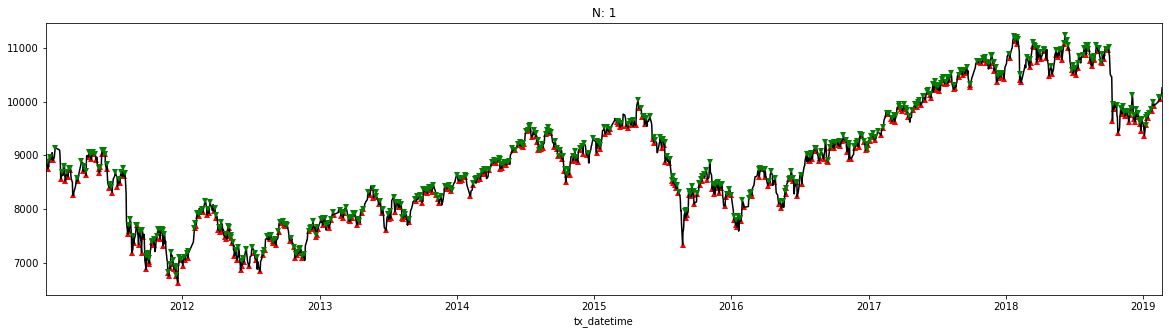

In [98]:
plot_turnpt(df_turnpt_ohlc, N)

,tx_datetime,is_turnpt,open,high,low,close,vol,maturity,day_to_maturity,N,is_turnpt_upward,is_turnpt_downward
0,2011-01-03,0,9000.0,9030.0,8995.0,9020.0,122732.0,2011-01-19,-16,NaN,NaN,NaN
1,2011-01-04,0,9030.0,9030.0,8974.0,8978.0,124896.0,2011-01-19,-15,NaN,NaN,NaN
2,2011-01-05,1,8967.0,9005.0,8791.0,8838.0,331662.0,2011-01-19,-14,1.0,1.0,0.0
3,2011-01-06,-1,8859.0,8876.0,8815.0,8869.0,165020.0,2011-01-19,-13,1.0,0.0,1.0
4,2011-01-07,1,8866.0,8883.0,8727.0,8753.0,257504.0,2011-01-19,-12,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2019-02-14,0,10044.0,10124.0,10034.0,10080.0,193056.0,2019-02-20,-6,NaN,NaN,NaN
1997,2019-02-15,1,10040.0,10116.0,10022.0,10042.0,223160.0,2019-02-20,-5,NaN,NaN,NaN
1998,2019-02-18,0,10111.0,10161.0,10098.0,10135.0,193704.0,2019-02-20,-2,NaN,NaN,NaN
1999,2019-02-19,0,10123.0,10158.0,10104.0,10142.0,143182.0,2019-02-20,-1,NaN,NaN,NaN


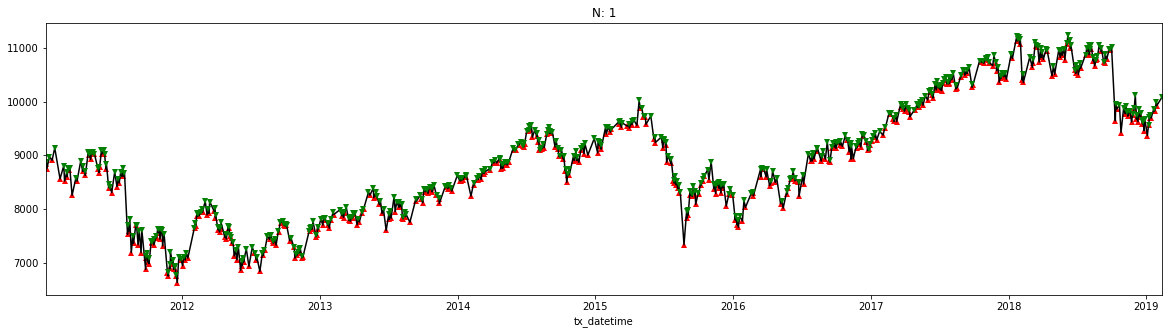

In [104]:
df_turnpt_ohlc_combined = get_combined_turnpt(df_turnpt_ohlc)
plot_turnpt(df_turnpt_ohlc_combined, N)
df_turnpt_ohlc_combined

In [100]:
df_turnpt_ohlc_combined.groupby('day_to_maturity').apply(lambda x: x.is_turnpt.abs().sum()).to_frame('num_turnpt')

,num_turnpt
day_to_maturity,
-35,0
-34,1
-33,15
-32,0
-31,0
-30,17
-29,20
-28,17
-27,18


## summarize turning points by day-to-maturity
    - frequency
    - slope
    - duration
    - optimal lambda


In [148]:
df_turnpt_measures = get_turnpt_magnitude(df_turnpt_ohlc_combined, N)
df_turnpt_measures

,tx_datetime,is_turnpt,open,high,low,close,vol,maturity,day_to_maturity,N,is_turnpt_upward,is_turnpt_downward,next_dt_turnpt,duration,prc_diff,slope
0,2011-01-03,0,9000.0,9030.0,8995.0,9020.0,122732.0,2011-01-19,-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-01-04,0,9030.0,9030.0,8974.0,8978.0,124896.0,2011-01-19,-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-01-05,1,8967.0,9005.0,8791.0,8838.0,331662.0,2011-01-19,-14,1.0,1.0,0.0,2011-01-06,1.0,31.0,31.0
3,2011-01-06,-1,8859.0,8876.0,8815.0,8869.0,165020.0,2011-01-19,-13,1.0,0.0,1.0,2011-01-07,1.0,-116.0,-116.0
4,2011-01-07,1,8866.0,8883.0,8727.0,8753.0,257504.0,2011-01-19,-12,1.0,1.0,0.0,2011-01-14,7.0,217.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2019-02-14,0,10044.0,10124.0,10034.0,10080.0,193056.0,2019-02-20,-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1997,2019-02-15,1,10040.0,10116.0,10022.0,10042.0,223160.0,2019-02-20,-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998,2019-02-18,0,10111.0,10161.0,10098.0,10135.0,193704.0,2019-02-20,-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999,2019-02-19,0,10123.0,10158.0,10104.0,10142.0,143182.0,2019-02-20,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


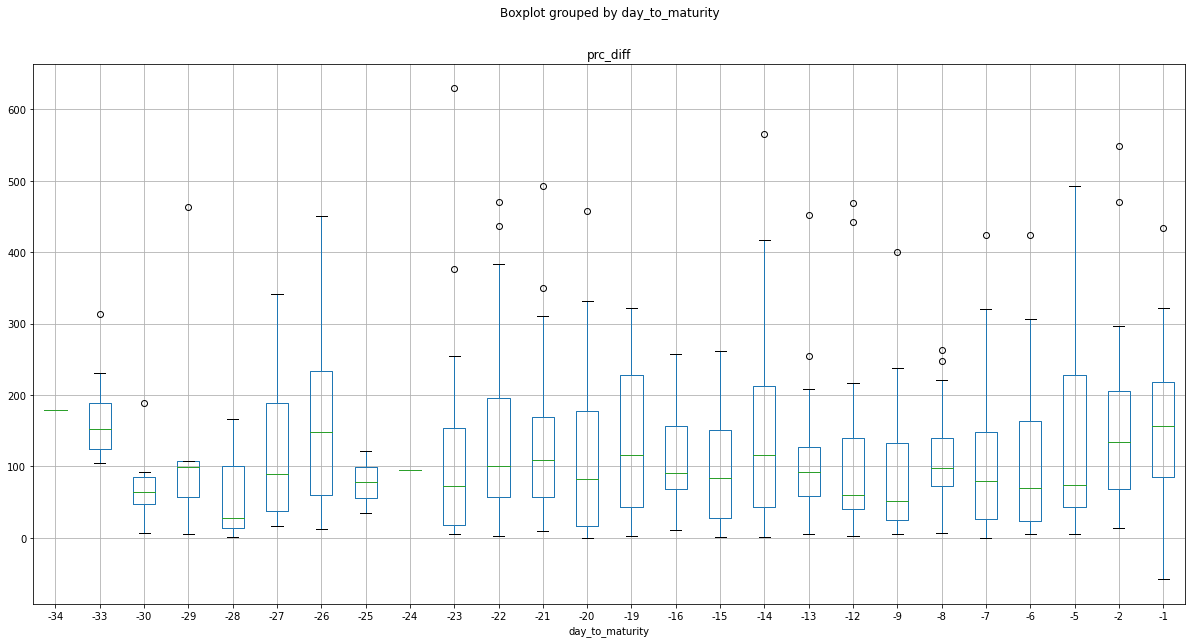

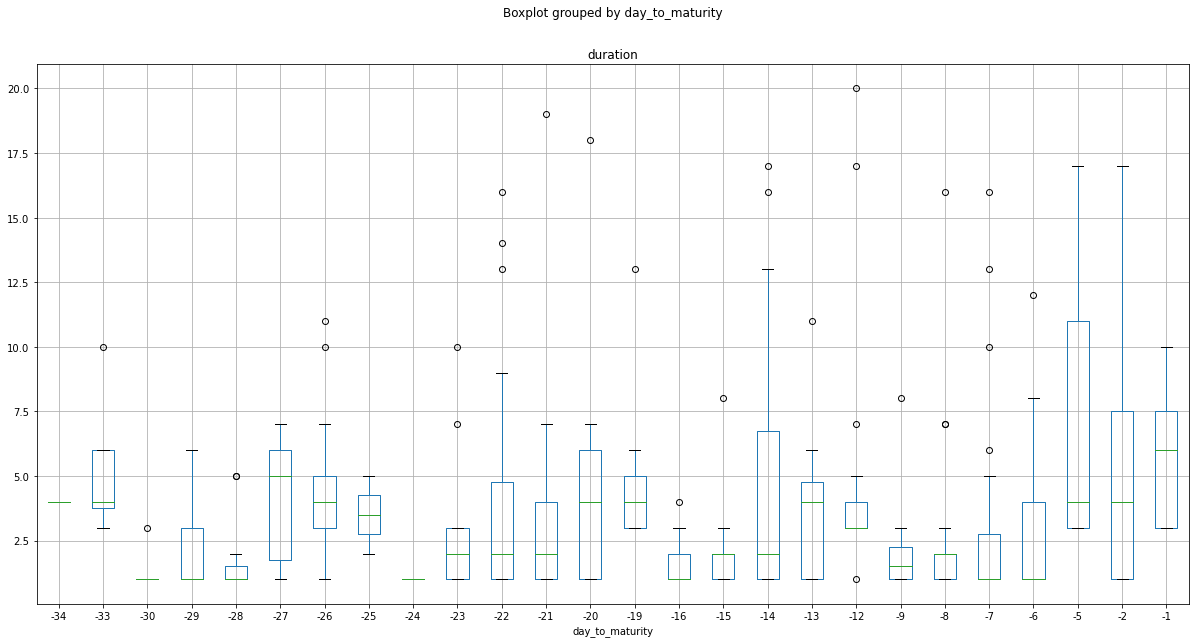

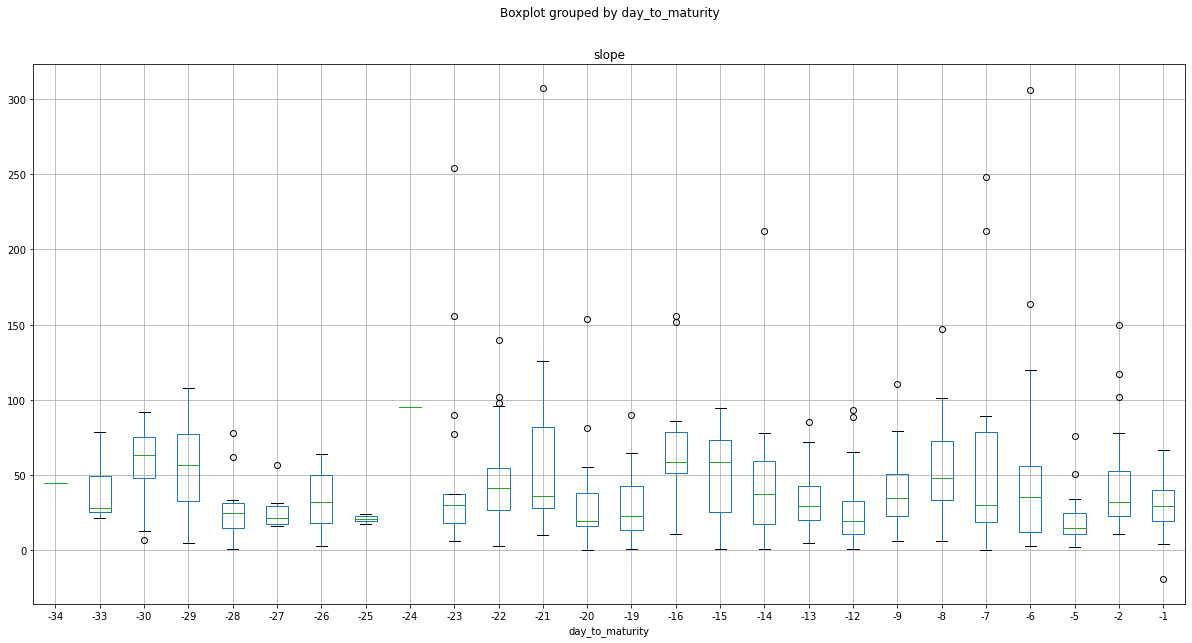

In [156]:
df_plot_turn_upward = df_turnpt_measures.query('is_turnpt_upward == 1')
df_plot_turn_upward.boxplot('prc_diff', by = 'day_to_maturity', figsize = (20, 10))
df_plot_turn_upward.boxplot('duration', by = 'day_to_maturity', figsize = (20, 10))
df_plot_turn_upward.boxplot('slope', by = 'day_to_maturity', figsize = (20, 10))

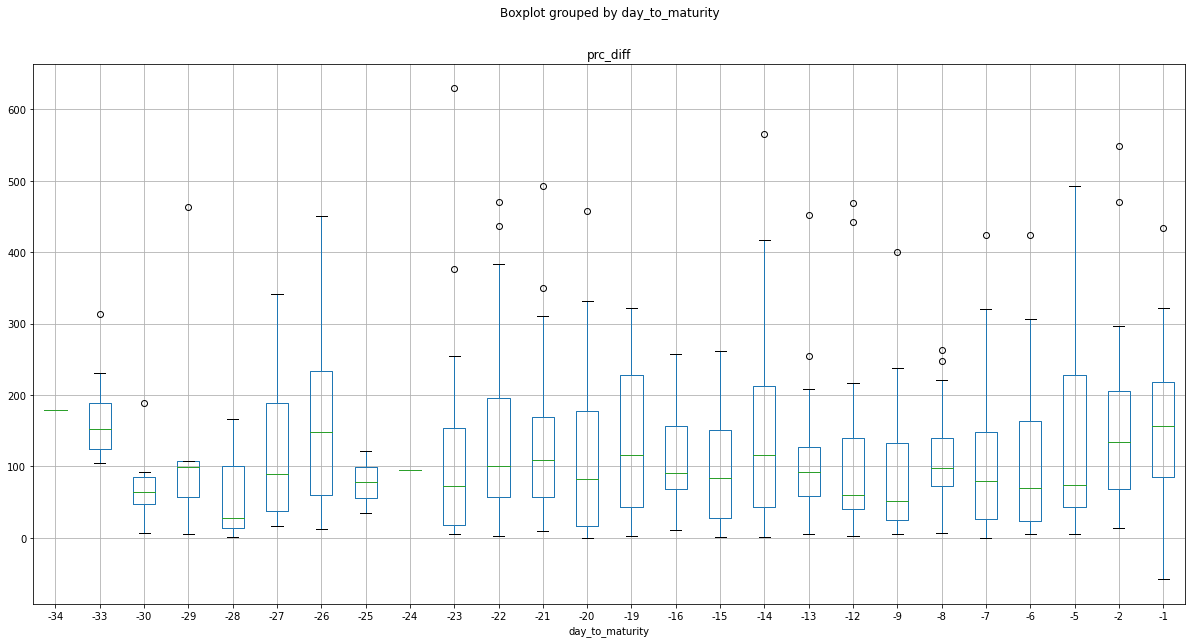

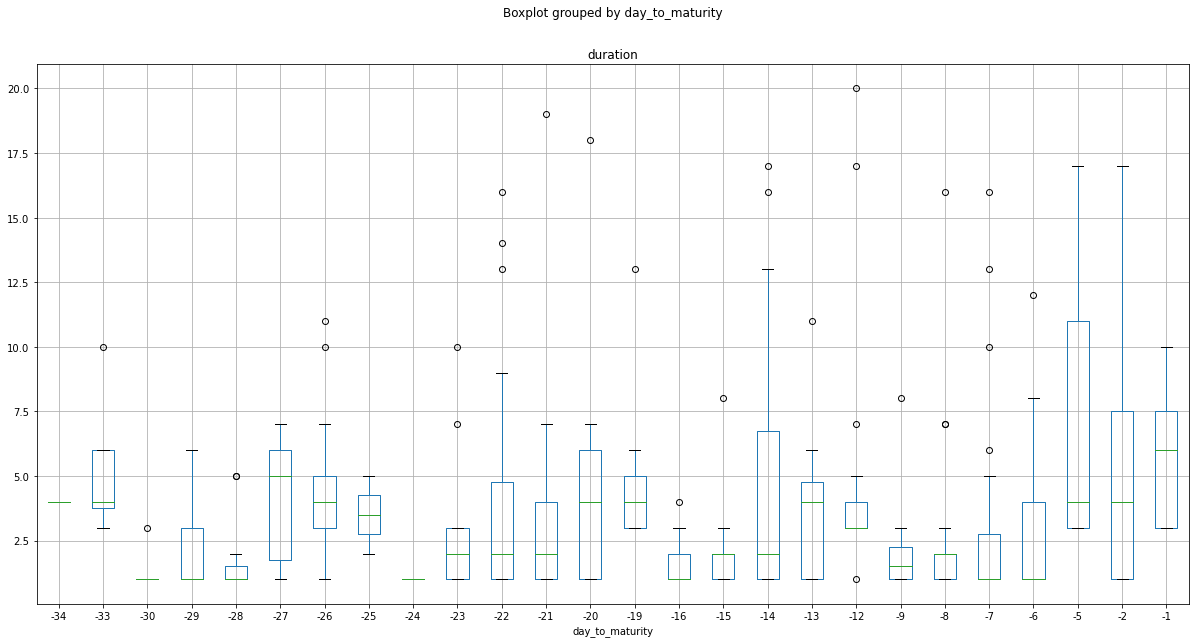

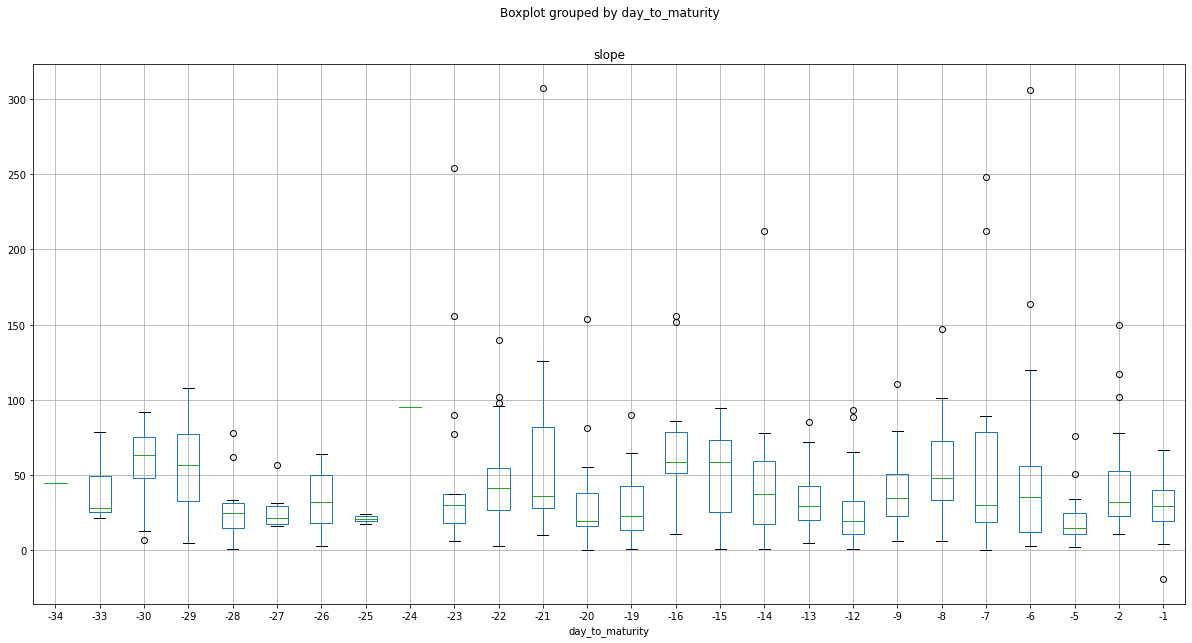

In [157]:
df_plot_turn_downward = df_turnpt_measures.query('is_turnpt_upward == 1')
df_plot_turn_downward.boxplot('prc_diff', by = 'day_to_maturity', figsize = (20, 10))
df_plot_turn_downward.boxplot('duration', by = 'day_to_maturity', figsize = (20, 10))
df_plot_turn_downward.boxplot('slope', by = 'day_to_maturity', figsize = (20, 10))

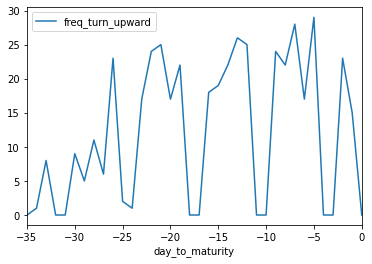

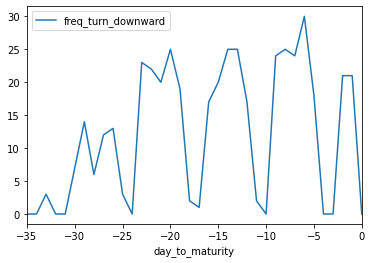

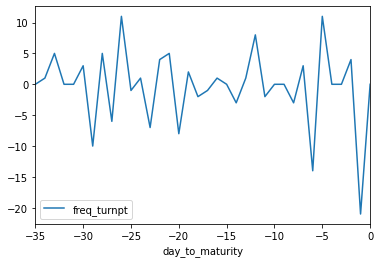

In [160]:
df_turnpt_measures.groupby('day_to_maturity').is_turnpt_upward.sum().to_frame('freq_turn_upward').plot()
df_turnpt_measures.groupby('day_to_maturity').is_turnpt_downward.sum().to_frame('freq_turn_downward').plot()
df_turnpt_measures.groupby('day_to_maturity').is_turnpt.sum().to_frame('freq_turnpt').plot()

In [164]:
df_analysis = df_turnpt_measures.groupby('day_to_maturity').agg({
    'is_turnpt_upward': sum,
    'is_turnpt_downward': sum,
    'is_turnpt': lambda x: x.abs().sum(),
    'prc_diff': 'mean',
    'duration': 'mean',
    'slope': 'mean'
})
df_analysis

,is_turnpt_upward,is_turnpt_downward,is_turnpt,prc_diff,duration,slope
day_to_maturity,,,,,,
-35,0.0,0.0,0,NaN,NaN,NaN
-34,1.0,0.0,1,179.000000,4.000000,44.750000
-33,8.0,3.0,15,106.090909,4.454545,21.865152
-32,0.0,0.0,0,NaN,NaN,NaN
-31,0.0,0.0,0,NaN,NaN,NaN
-30,9.0,7.0,17,-10.562500,1.750000,15.515625
-29,5.0,14.0,20,-45.736842,2.315789,-22.677945
-28,11.0,6.0,17,-0.705882,1.705882,-7.064706
-27,6.0,12.0,18,-28.000000,3.222222,-36.830026


# which N is the best?
- check trading opportunity